In [1]:
# Extract images from Zip file and move to 'images' folder
!mkdir images
!unzip images.zip
!mv *.png images/

import os
import shutil
import random
import pandas as pd

def move_random_images(src_dir, dest_dir, prefix, num_images):
    """
    Moves a specified number of random images with a given prefix from the source directory 
    to the destination directory.

    Args:
        src_dir (str): Source directory containing images.
        dest_dir (str): Destination directory to move images to.
        prefix (str): Prefix of images to search for.
        num_images (int): Number of images to move.
    """
    # Ensure destination directory exists
    os.makedirs(dest_dir, exist_ok=True)
    
    # Get all images with the specified prefix
    images = [img for img in os.listdir(src_dir) if img.startswith(prefix)]
    
    # Randomly select the specified number of images
    selected_images = random.sample(images, num_images)
    
    # Move each selected image to the destination directory
    for img in selected_images:
        shutil.move(os.path.join(src_dir, img), os.path.join(dest_dir, img))
        print(f"Moved {img} to {dest_dir}")

# Directory paths
source_directory = './images'  # Change as needed
destination_directory = './val_images'  # Folder to store selected images

# Move images
move_random_images(source_directory, destination_directory, 'BPF_', 125)
move_random_images(source_directory, destination_directory, 'LPF_', 125)
move_random_images(source_directory, destination_directory, 'HPF_', 125)
move_random_images(source_directory, destination_directory, 'notch_', 125)


def update_annotations(original_csv, moved_images_dir, new_csv):
    """
    Updates annotations by moving entries for specified images from the original CSV 
    to a new CSV.

    Args:
        original_csv (str): Path to the original annotations CSV.
        moved_images_dir (str): Directory containing moved images.
        new_csv (str): Path for the new annotations CSV.
    """
    # Read the original annotations CSV
    annotations = pd.read_csv(original_csv)
    
    # Extract the image filenames from the moved images directory
    moved_images = set(os.listdir(moved_images_dir))
    
    # Split the dataset into moved set and remaining set
    is_moved = annotations.iloc[:, 0].apply(lambda img_name: img_name in moved_images)
    moved_annotations = annotations[is_moved]
    remaining_annotations = annotations[~is_moved]
    
    # Write the moved annotations to a new CSV
    moved_annotations.to_csv(new_csv, index=False)
    
    # Optionally, you can overwrite the original CSV without the moved entries
    remaining_annotations.to_csv(original_csv, index=False, header=True)
    
    print(f"Moved {len(moved_annotations)} entries to {new_csv}.")

# Define paths
original_annotations_path = 'annotations.csv'  # Path to your original annotations file
moved_images_directory = './val_images'  # Directory where images were moved
new_annotations_path = 'val_annotations.csv'  # Path for the new validation annotations file

# Update annotations
update_annotations(original_annotations_path, moved_images_directory, new_annotations_path)

Archive:  images.zip
  inflating: images/BPF_length170.0_length2120.0_height20.0_sep20.0.png  
  inflating: images/BPF_length170.0_length2120.0_height20.0_sep35.0.png  
  inflating: images/BPF_length170.0_length2120.0_height20.0_sep50.0.png  
  inflating: images/BPF_length170.0_length2120.0_height20.0_sep65.0.png  
  inflating: images/BPF_length170.0_length2120.0_height20.0_sep80.0.png  
  inflating: images/BPF_length170.0_length2120.0_height25.0_sep20.0.png  
  inflating: images/BPF_length170.0_length2120.0_height25.0_sep35.0.png  
  inflating: images/BPF_length170.0_length2120.0_height25.0_sep50.0.png  
  inflating: images/BPF_length170.0_length2120.0_height25.0_sep65.0.png  
  inflating: images/BPF_length170.0_length2120.0_height25.0_sep80.0.png  
  inflating: images/BPF_length170.0_length2120.0_height30.0_sep20.0.png  
  inflating: images/BPF_length170.0_length2120.0_height30.0_sep35.0.png  
  inflating: images/BPF_length170.0_length2120.0_height30.0_sep50.0.png  
  inflating: imag

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torch.amp import GradScaler, autocast
import pandas as pd
from PIL import Image
import random
import time
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import re
import os
from tqdm import tqdm
import csv

# Set Environment variable for Cuda
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Initialize the custom dataset.

        Args:
            csv_file (str): Path to the CSV file containing image annotations.
            img_dir (str): Directory path where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)    # Read annotations CSV file
        self.img_dir = img_dir                      # Image directory path
        self.transform = transform                  # Image transformer (for manipulating image sizes)

    def __len__(self):
        """
        Return the total number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset (size of annotations file).
        """
        return len(self.annotations)  # Size of annotations file

    def __getitem__(self, index):
        """
        Retrieve a sample from the dataset at the specified index.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            Tuple[image, torch.Tensor]: A tuple of the transformed image and its corresponding frequency annotations.
        """
        img_name = self.annotations.iloc[index, 0]  # Get the name of the image at the specified index
        image = Image.open(f"{self.img_dir}/{img_name}").convert('RGB')  # Open the image and convert to RGB if not already

        if self.transform:
            image = self.transform(image)  # Transform image (resize and change to Tensor type)

        frequencies = self.annotations.iloc[index, 1:].values.astype(float)  # Extract annotations (frequency response values)
        
        return image, torch.tensor(frequencies, dtype=torch.float32)  # Return the image and its annotation (both as tensors)

In [3]:
# Define Global Variables
image_width = 450                       # Set image width to be used for resizing images
image_height = 300                      # Set image height to be used for resizing images
train_img_dir = './images'              # Path to directory containing images for training
train_csv_file = './annotations.csv'    # Path to CSV file containing annotations for the images
val_img_dir = './val_images'            # Path to directory containing images for training
val_csv_file = './val_annotations.csv'  # Path to CSV file containing annotations for the images
num_outputs = 381                       # Number of output classes or target values for the model

# Define image transformer (changes input image dimensions and changes them to tensors)
transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),  # Resize images to the specified height and width
    transforms.ToTensor(),                           # Convert images to PyTorch tensors
])

# Create and load dataset
train_dataset = CustomDataset(csv_file=train_csv_file, img_dir=train_img_dir, transform=transform)  # Initialize training dataset with transformations
val_dataset = CustomDataset(csv_file=val_csv_file, img_dir=val_img_dir, transform=transform)        # Initialize validation dataset

# Create data loaders for training and validation datasets
train_loader = DataLoader(
    train_dataset,  # Dataset for training
    batch_size=80,  # Number of samples per batch for training
    shuffle=True    # Shuffle training data after every epoch
)
val_loader = DataLoader(
    val_dataset,    # Dataset for validation
    batch_size=8,   # Number of samples per batch for validation
    shuffle=True    # Shuffle validation data to ensure randomness
)

In [4]:
def calculate_linears(num_layers: int, dim: list, conv_filter_size: int, conv_stride: int, maxp_filter_size: int, maxp_stride: int, padding: int) -> list:
    """
    Calculate the output dimensions of a series of convolutional and max pooling layers
    (Calculates the number of input neurons for the linear fully-connected layer).

    Args:
        num_layers (int): Number of convolutional and pooling layers.
        dim (list): Initial dimensions [width, height] of the input.
        conv_filter_size (int): Size of the convolutional filter (assumed square).
        conv_stride (int): Stride for the convolutional layers.
        maxp_filter_size (int): Size of the max pooling filter (assumed square).
        maxp_stride (int): Stride for the max pooling operation.
        padding (int): Amount of zero-padding added to both sides of the input.

    Returns:
        list: Final dimensions [width, height] after all layers are applied.
    """
    output = [dim[0], dim[1]]  # Initialize with the input dimensions (width, height)
    for i in range(num_layers):
        # Calculate convolution output dimensions using the given formula
        conv_output_width = ((output[0] - conv_filter_size + (2 * padding)) / conv_stride) + 1
        conv_output_height = ((output[1] - conv_filter_size + (2 * padding)) / conv_stride) + 1
        
        # Update output to convolution result dimensions
        output = [conv_output_width, conv_output_height]
        
        # Calculate max pooling output dimensions using the given formula
        pool_output_width = ((output[0] - maxp_filter_size) / maxp_stride) + 1
        pool_output_height = ((output[1] - maxp_filter_size) / maxp_stride) + 1
        
        # Update output to pooling result dimensions, converting to int for layer compatibility
        output = [int(pool_output_width), int(pool_output_height)]
    
    return output  # Return final dimensions after all layers are applied

In [5]:
# Circuit Convolution neural network configuration
input_layers = 3  # Number of input layers, typically corresponding to the color channels of an image (e.g., RGB)
Conv1_output_layers = 32  # Number of output channels for the first convolutional layer
Conv2_output_layers = Conv1_output_layers * 2  # Number of output channels for the second convolutional layer, doubling the previous layer
Conv3_output_layers = Conv2_output_layers * 2  # Number of output channels for the third convolutional layer, doubling again

conv_filter_size = 3  # Size of the convolutional filters (3x3)
conv_stride = 1  # Stride of the convolutional layer
maxp_filter_size = 2  # Size of the max pooling filters (2x2)
maxp_stride = 2  # Stride of the max pooling layer
padding = 1  # Padding added to the input of convolutional layers

# Calculate output dimensions after convolutional and pooling layers
linear_layers = calculate_linears(
    num_layers=3,  # Number of convolutional/pooling layers
    dim=[image_width, image_height],  # Initial image dimensions
    conv_filter_size=conv_filter_size,  # Convolution filter size
    conv_stride=conv_stride,  # Convolution stride
    maxp_filter_size=maxp_filter_size,  # Max pooling filter size
    maxp_stride=maxp_stride,  # Max pooling stride
    padding=padding  # Padding for convolutional layers
)

conv_flatten_widths = linear_layers[0]  # Final width after the convolutional layers
conv_flatten_heights = linear_layers[1]  # Final height after the convolutional layers

# Configuration for fully connected (linear) layers
Lin1_output_layers = 1024  # Number of output units for the first linear layer
Lin2_output_layers = Lin1_output_layers  # Number of output units for the second linear layer
Lin3_output_layers = Lin2_output_layers  # Number of output units for the third linear layer
Lin4_output_layers = Lin3_output_layers // 2  # Number of output units for the fourth linear layer, halving the previous layer
Lin5_output_layers = Lin4_output_layers // 2  # Number of output units for the fifth linear layer, halving again

dropout_prob = 0.1  # Probability for dropout, a regularization technique

# Calculate the number of neurons for the fully-connected layer after flattening
conv_flat_output = conv_flatten_widths * conv_flatten_heights * Conv3_output_layers  # Total number of neurons

In [6]:
class CircuitFrequencyResponseModel(nn.Module):
    def __init__(self, output_length):
        """
        Initialize the Circuit Frequency Response Model.

        Args:
            output_length (int): Length of the model output.
        """
        super(CircuitFrequencyResponseModel, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(input_layers, Conv1_output_layers, kernel_size=conv_filter_size, padding=padding)  # First convolutional layer
        self.conv2 = nn.Conv2d(Conv1_output_layers, Conv2_output_layers, kernel_size=conv_filter_size, padding=padding)  # Second convolutional layer
        self.conv3 = nn.Conv2d(Conv2_output_layers, Conv3_output_layers, kernel_size=conv_filter_size, padding=padding)  # Third convolutional layer
        
        self.pool = nn.MaxPool2d(kernel_size=maxp_filter_size, stride=maxp_stride)  # Max pooling layer
        
        # Fully connected layers
        self.fc1 = nn.Linear(conv_flat_output, Lin1_output_layers)  # First fully connected layer
        self.fc2 = nn.Linear(Lin1_output_layers, Lin2_output_layers)  # Second fully connected layer
        self.fc3 = nn.Linear(Lin2_output_layers, Lin3_output_layers)  # Third fully connected layer
        self.fc4 = nn.Linear(Lin3_output_layers, Lin4_output_layers)  # Fourth fully connected layer
        self.fc5 = nn.Linear(Lin4_output_layers, Lin5_output_layers)  # Fifth fully connected layer
        
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer to prevent overfitting
        
        # Output layer
        # Originally commented out, using Lin3_output_layers
        # self.fc_out = nn.Linear(Lin3_output_layers, output_length)
        self.fc_out = nn.Linear(Lin5_output_layers, output_length)  # Linear layer for the final output
        
        self.output_length = output_length  # Record the output length for reference

    def forward(self, x):
        """
        Define the forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor representing a batch of images.
        
        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        # Forward pass through convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten feature map before fully connected layers
        x = x.view(x.size(0), -1)
        
        # Forward pass through fully connected layers with ReLU and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        
        # Final output layer
        x = self.fc_out(x)
        
        return x

In [7]:
# Training Variables (Define the model, loss function, optimizer, and scheduler)
model = CircuitFrequencyResponseModel(output_length=num_outputs)  # Initialize the model with the specified output length
criterion = nn.MSELoss()  # Define the loss function (Mean Squared Error Loss)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)  # Initialize the optimizer (Adam) with a learning rate; alternatives commented
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( # Initialize a learning rate scheduler to reduce the learning rate when a plateau in validation loss is observed.
    optimizer,            # Optimizer whose learning rate will be adjusted
    mode='min',           # Mode of optimization ('min' since lower validation loss is better)
    factor=0.85,          # Factor by which the learning rate will be reduced
    patience=15,          # Number of epochs with no improvement after which learning rate will be reduced
    threshold=0.001,      # Threshold for measuring the new optimum for early stopping
)
# Move model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if CUDA is available, use GPU if so, else use CPU
model.to(device)  # Transfer model to the selected device

start_epoch = 0  # Starting epoch number, useful for resuming training
num_epochs = 600  # Total number of epochs for training

In [8]:
def load_checkpoint(desired_epoch, additional_epochs):
    """
    Load a training checkpoint from disk and resume training from a specified epoch.

    Raises:
        FileNotFoundError: If the checkpoint file does not exist at the specified path.
    """
    checkpoint_path = f"CapstoneFull_checkpoint_epoch_{desired_epoch}.pth"  # Path to the checkpoint file for the desired epoch

    try:
        # Load the checkpoint data
        checkpoint = torch.load(checkpoint_path)
        
        # Load the model state from the checkpoint
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Load the optimizer state from the checkpoint
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Load the scheduler state from the checkpoint
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Update the starting epoch number to resume training
        start_epoch = checkpoint['epoch']  # Start from the epoch following the one in the checkpoint
        print(f"Resuming training from epoch {start_epoch}")  # Print a message indicating resumption
        num_epochs = start_epoch + additional_epochs
        return start_epoch, num_epochs

    except FileNotFoundError:
        # Print a message if no checkpoint is found
        print("No checkpoint found, starting training from scratch.")

In [ ]:
# Used if training needs to be resumed from a checkpoint.
use_checkpoint = False
if use_checkpoint:       
    start_epoch, num_epochs = load_checkpoint(600, 50)

# Store the metrics for each epoch
metrics = []

# Loop over the dataset multiple times, where each loop is a complete pass over the data (an epoch)
for epoch in range(start_epoch, num_epochs):
    model.train()  # Set the model to training mode to ensure training-specific operations are active
    running_loss = 0.0  # Initialize the running loss to accumulate total loss for the epoch
    
    # Iterate over batches of images and targets from the training data
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, targets = images.to(device), targets.to(device)  # Move images and targets to the designated device (CPU or GPU)
        optimizer.zero_grad()     # Clear the gradients of all optimized tensors
        
        outputs = model(images)   # Forward pass: compute the model output for the batch of images
        loss = criterion(outputs.squeeze(-1), targets)  # Compute the loss between model predictions and actual targets
        
        loss.backward()  # Backward pass: compute gradients of the loss with respect to model parameters
        optimizer.step()  # Update model parameters based on the computed gradients
        
        running_loss += loss.item()  # Accumulate the batch loss into running loss
    
    # Compute the average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")  # Print the average training loss for the epoch
    
    model.eval()  # Set the model to evaluation mode, affecting certain layers which behave differently during evaluation (e.g., dropout)
    val_loss = 0.0  # Initialize validation loss accumulator
    
    # Disable gradient computation for validation to save memory and computation
    with torch.no_grad():
        # Iterate over validation dataset
        for val_images, val_targets in val_loader:
            val_images, val_targets = val_images.to(device), val_targets.to(device)  # Move validation data to the device
            val_outputs = model(val_images)  # Compute model output for validation data
            v_loss = criterion(val_outputs.squeeze(-1), val_targets)  # Calculate validation loss
            val_loss += v_loss.item()  # Accumulate validation loss
    
    # Compute the average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Current LR: {scheduler.get_last_lr()}")  # Print the average validation loss
    
    scheduler.step(avg_val_loss)  # Update the learning rate based on validation loss

    # Save metrics for this epoch
    metrics.append([epoch + 1, avg_loss, avg_val_loss, scheduler.get_last_lr()[-1]])   
    
    # Save a checkpoint every 50 epochs
    if (epoch + 1) % 50 == 0:
        checkpoint = {
            'epoch': epoch + 1,                        # Current epoch number
            'model_state_dict': model.state_dict(),    # Model parameters
            'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
            'scheduler_state_dict': scheduler.state_dict(),  # Scheduler state
            'loss': avg_loss                           # Latest training loss
        }
        torch.save(checkpoint, f"CapstoneFull_checkpoint_epoch_{epoch + 1}.pth")  # Save the checkpoint to a file
        print(f"Checkpoint saved at epoch {epoch + 1}")  # Notify that checkpoint is saved

print("Training complete!")  # Indicate that training has finished

# Save the final model parameters to a file
torch.save(model.state_dict(), f'CapstoneFull_Complete_V6.pth')

# Write metrics to a CSV file
with open('training_metrics.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Learning Rate'])
    writer.writerows(metrics)

print("Metrics saved to 'training_metrics.csv'")

Epoch 1/600:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 21/25 [00:27<00:05,  1.27s/it]

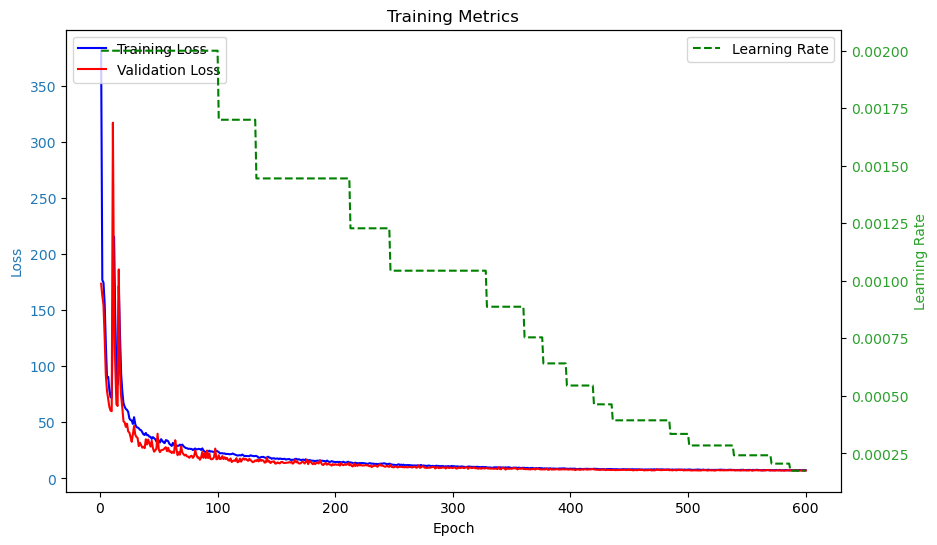

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_training_metrics(csv_file, output_image):
    # Load the data from the CSV file
    data = pd.read_csv(csv_file)

    epochs = data['Epoch']
    train_loss = data['Training Loss']
    val_loss = data['Validation Loss']
    learning_rate = data['Learning Rate']

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation loss
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')

    # Create a second y-axis for the learning rate
    ax2 = ax1.twinx()
    ax2.set_ylabel('Learning Rate', color='tab:green')
    ax2.plot(epochs, learning_rate, 'g--', label='Learning Rate')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.legend(loc='upper right')

    # Add a title
    plt.title('Training Metrics')

    # Save the plot as an image file
    plt.savefig(output_image, format='png', dpi=800, bbox_inches='tight')

    # Show the plot
    plt.show()

# Call the function to create and save the plot
plot_training_metrics('training_metrics.csv', 'training_metrics_plot.png')

In [9]:
# Code for Output Prediction:
import pandas as pd
import matplotlib.pyplot as plt

def predict_output(model, image_path, transform):
    """
    Predict the output of a model given an image path and a transform.

    Args:
        model (nn.Module): The trained model used for prediction.
        image_path (str): Path to the image file to be analyzed.
        transform (callable): Transformation to be applied to the image.

    Returns:
        numpy.ndarray or None: The flattened array of predicted outputs or None if prediction fails.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        image = Image.open(image_path).convert('RGB')  # Open and convert the image to RGB
        image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
        output = model(image)  # Run the image through the model to get the output
        
        if output is not None:  # Check if the output is valid
            predicted_outputs = output.cpu().numpy().flatten()  # Convert the output to a NumPy array and flatten it
            return predicted_outputs  # Return the predicted outputs
        else:
            return None

def choose_random_file(directory):
    """
    Choose a random file from the specified directory.

    Args:
        directory (str): The directory to search for files.

    Returns:
        str or None: Path to a randomly selected file from the directory or None if no files are present.
    """
    # Get a list of files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Check if there are any files in the directory
    if not files:
        return None
    
    # Choose a random file
    return random.choice(files)

def plot_predictions_vs_real(image_name, predicted_values, output_image, freq_start=1, freq_end=20):
    """
    Plot predicted values against real values for a given image name.

    Args:
        image_name (str): The name of the image file to compare.
        predicted_values (numpy.ndarray): The predicted values to compare against the real ones.

    Returns:
        Tuple[float, float]: Total difference and average difference between real and predicted values.
    """
    # Load the CSV file containing annotations
    annotations_df = pd.read_csv('./val_annotations.csv')
    
    # Find the row corresponding to the image name
    image_row = annotations_df[annotations_df['Image Name'] == image_name]
    
    if image_row.empty:  # Check if the image name was found in the CSV
        print(f"No entry found for image: {image_name}")
        return
    
    # Assuming the real values are stored in subsequent columns
    real_values = image_row.iloc[:, 1:].values.flatten()  # This grabs all columns except 'image_name'
    
    # Check if predicted_values match the length of real_values
    if len(predicted_values) != len(real_values):
        print("Mismatch between predicted values and real values length.")
        return
    
    # Calculate the total difference (sum of absolute differences)
    total_difference = sum(abs(real_values[i] - predicted_values[i]) for i in range(len(real_values)))
    
    # Plotting the graph
    frequency = np.linspace(freq_start, freq_end, len(real_values))
    plt.figure(figsize=(10, 6))
    plt.plot(frequency, real_values, label='Real Values', color='blue', marker='o', linestyle='-', markersize=5)  # Plot real values
    plt.plot(frequency, predicted_values, label='Predicted Values', color='red', marker='x', linestyle='--', markersize=5)  # Plot predicted values
    
    plt.title(f"Real vs Predicted Values for {image_name}")  # Title for the plot
    plt.xlabel('Frequency [GHz]')  # X-axis label
    plt.ylabel('S21 Parameter [dB]')  # Y-axis label
    plt.legend()  # Add a legend

    # Add major and minor grid lines
    plt.grid(which='both', linestyle='--', linewidth=0.5)  # Major grid
    plt.minorticks_on()  # Enable minor ticks to help display minor grid lines
    plt.grid(which='minor', linestyle=':', linewidth=0.3, color='gray')  # Minor grid
    
    plt.savefig(output_image, format='png', dpi=800, bbox_inches='tight') # Save the plot as an image file

    plt.show()  # Display the plot

    return total_difference, total_difference / len(real_values)   # Return total and average differences

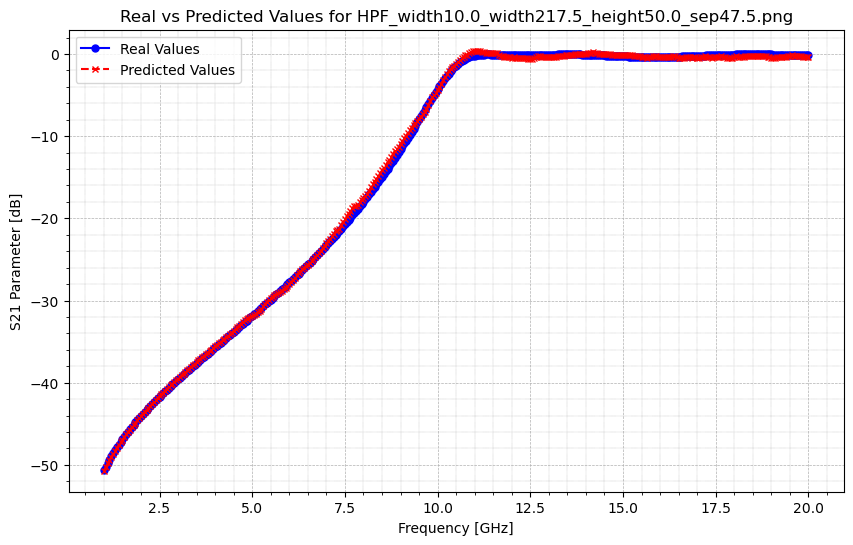

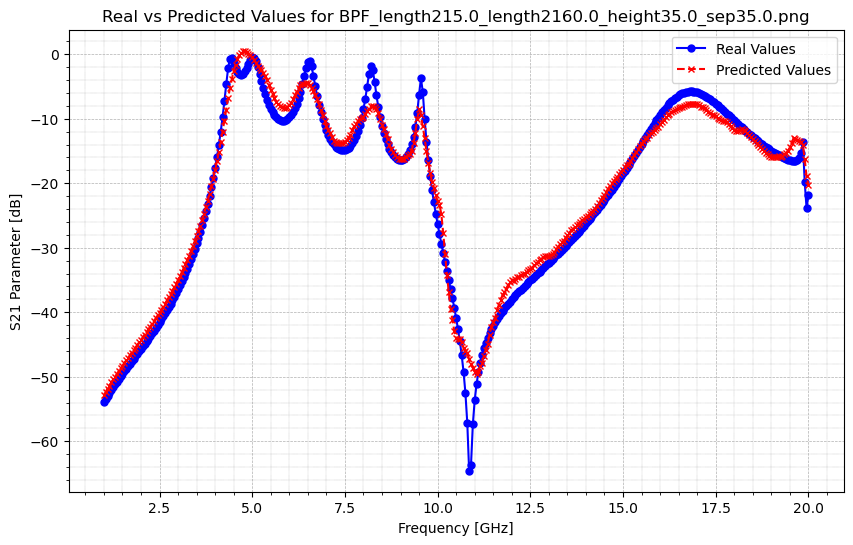

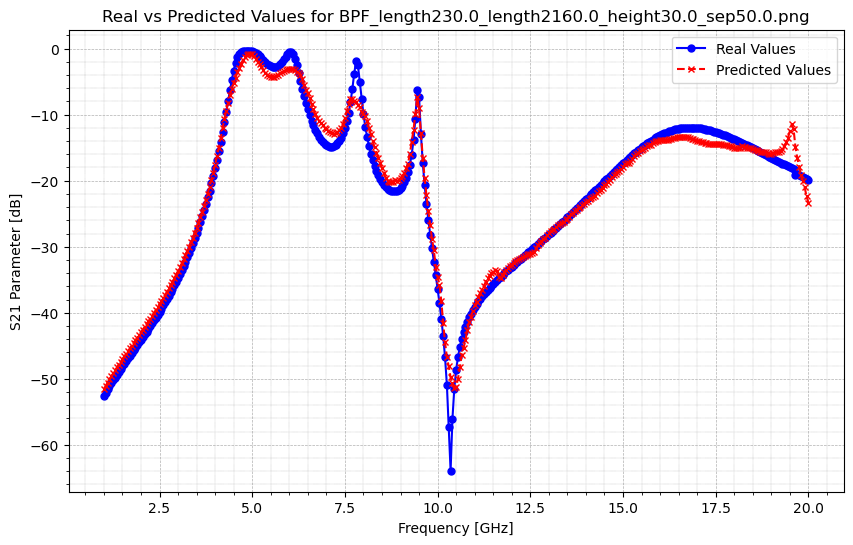

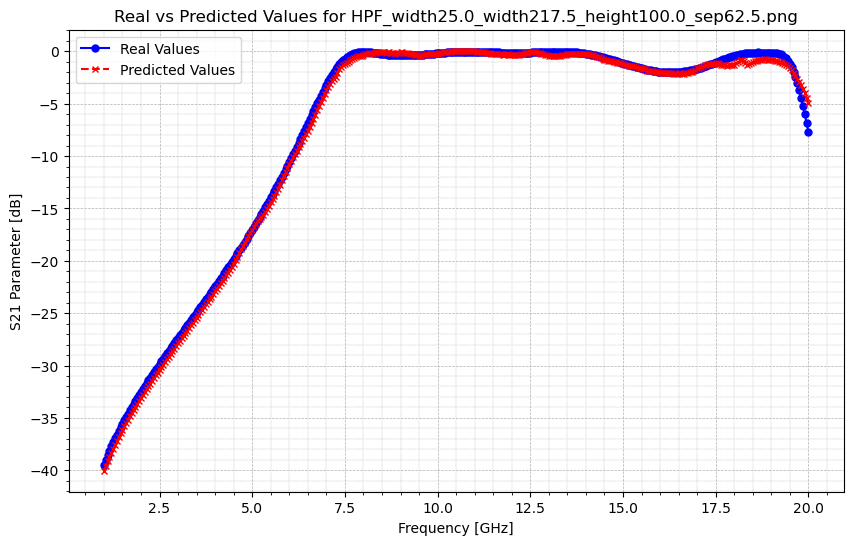

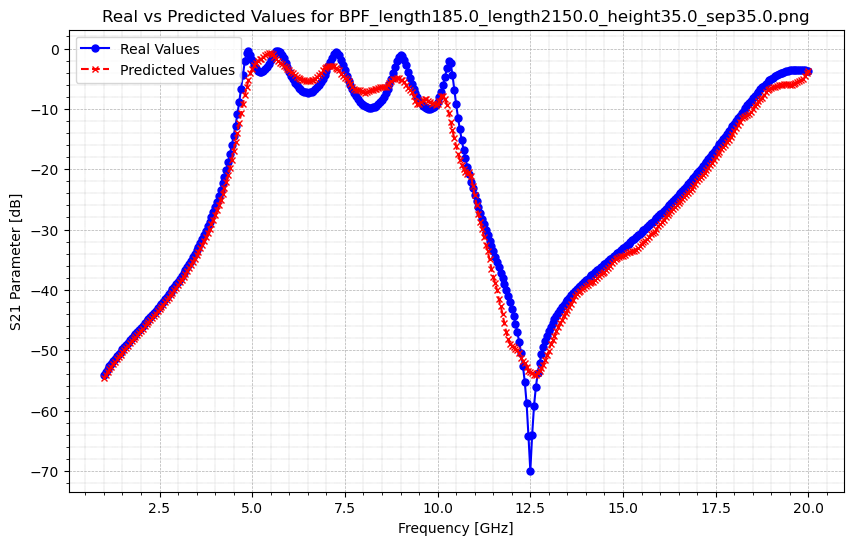

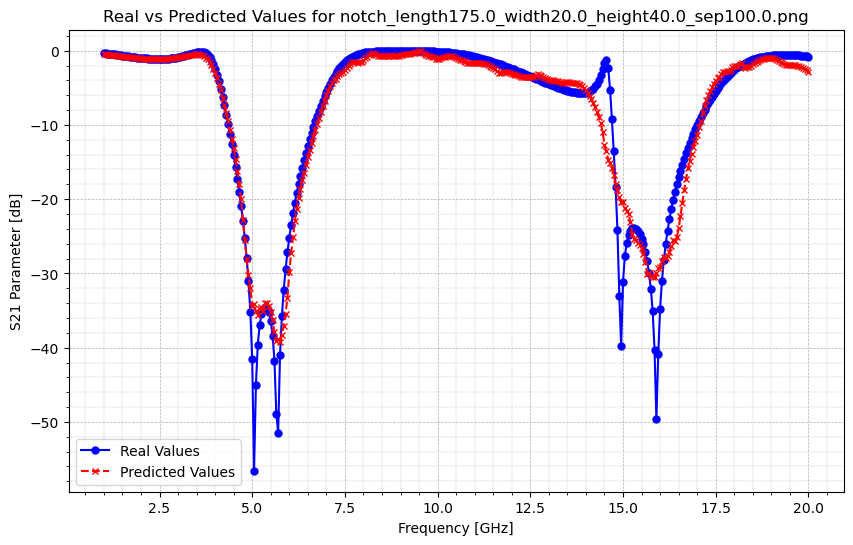

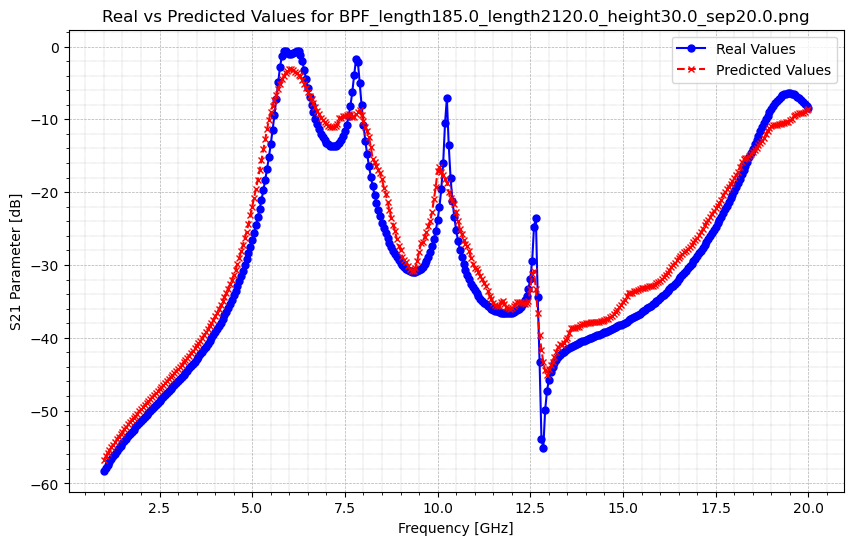

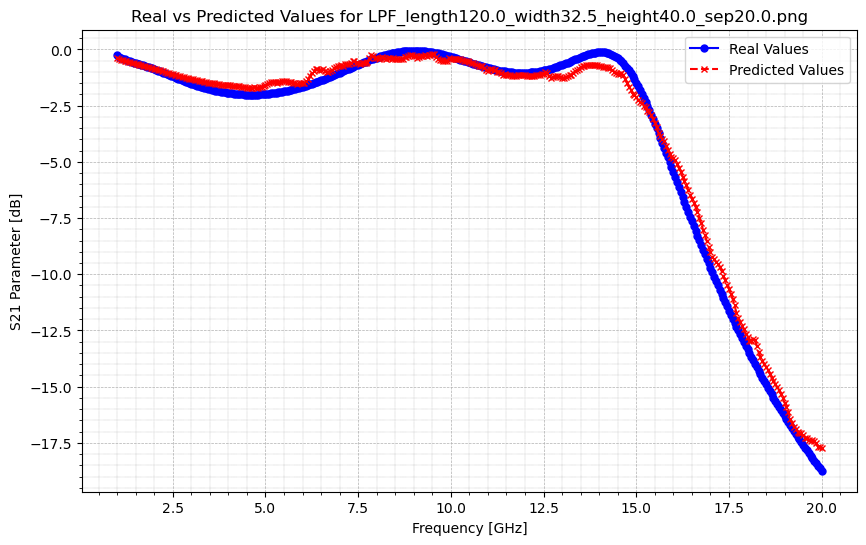

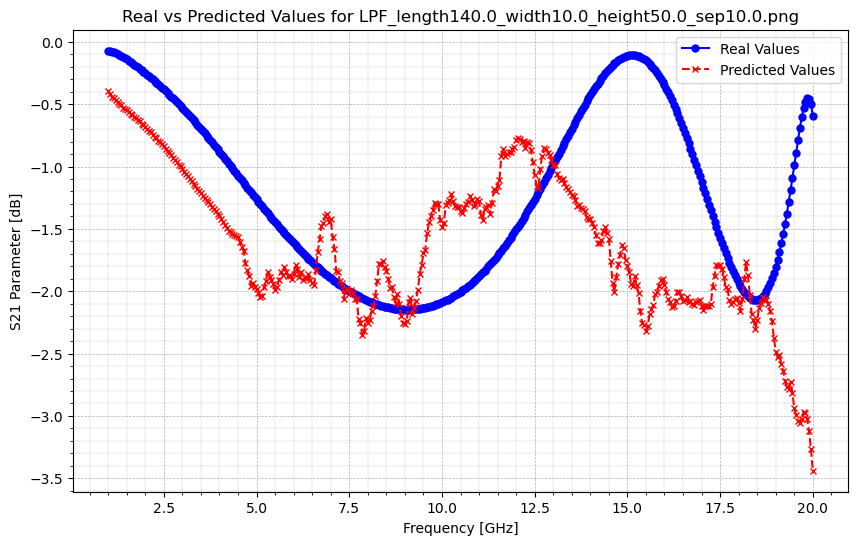

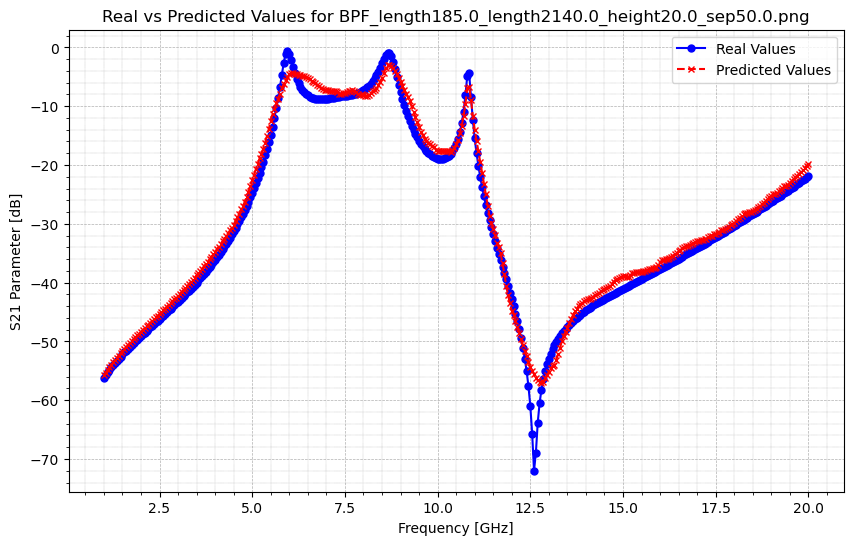

Total Time taken for predicting 10 images: 13.84139370918274
Worst Case single frequency discrepancy: 2.5478
Average single frequency discrepancy across 10 samples: 1.1957


In [14]:
model_path = f'./CapstoneFull_Complete_V5.pth'  # Path to the saved neural network model

# Initialize the neural network with the specified output length
net = CircuitFrequencyResponseModel(output_length=num_outputs)  

# Load only the weights from the neural network model, using CPU as the map location
net.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))

t0 = 0  # Initialize the variable to track the worst-case total discrepancy
a0 = 0  # Initialize the accumulator variable for average discrepancies

check_range = 10  # Number of samples over which to check and average discrepancies
checked_images = [0] * check_range # Array to store already processed images


old_time = time.time()
for i in range(check_range):
    # Select a random test image from the validation set
    test_image = choose_random_file("./val_images")  
    while test_image in checked_images:
        test_image = choose_random_file("./val_images")
    image_path = f'./val_images/{test_image}'  # Construct the full path to the image
    checked_images[i] = test_image
    
    # Obtain predicted values for the image using the neural network
    predicted_values = predict_output(net, image_path, transform)  
    
    # Plot predictions against real values and retrieve total and average discrepancy and % Error
    t, a = plot_predictions_vs_real(test_image, predicted_values, 'val_' + test_image)
    
    # Update worst case discrepancy if the current one is greater
    if t > t0:
        t0 = t
    
    # Add the average discrepancy to the accumulator
    a0 += a
print(f"Total Time taken for predicting {check_range} images: {time.time() - old_time}")

# Calculate and print the worst-case single total discrepancy
print(f"Worst Case single frequency discrepancy: {(t0/num_outputs):.4f}")

# Calculate and print the average single discrepancy across all samples
print(f"Average single frequency discrepancy across {check_range} samples: {(a0/check_range):.4f}")

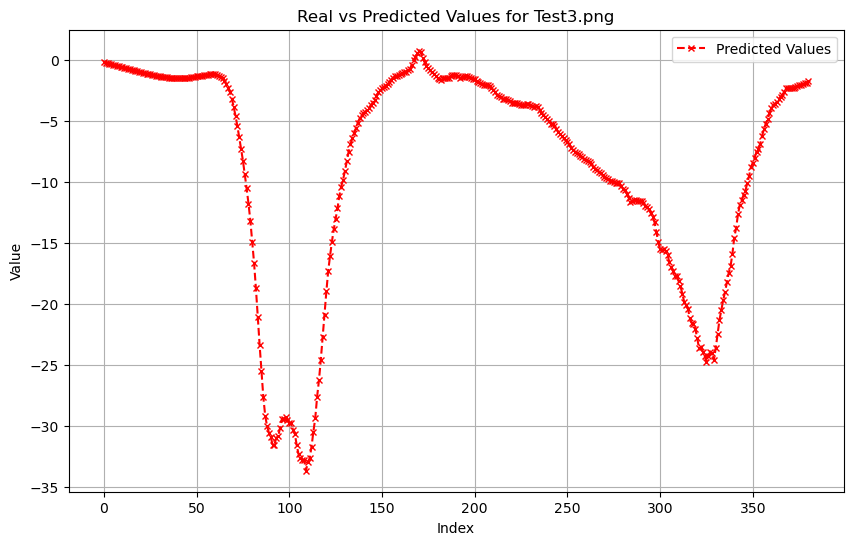

Worst Case single frequency discrepancy: 447.3671
Average single frequency discrepancy across 1 samples: 1.1742


In [19]:
model_path = f'./CapstoneFull_Complete_V4.pth'  # Path to the saved neural network model

# Initialize the neural network with the specified output length
net = CircuitFrequencyResponseModel(output_length=num_outputs)  

# Load only the weights from the neural network model, using CPU as the map location
net.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))

test_image = "Test3.png"  
image_path = f'./{test_image}'  # Construct the full path to the image

# Obtain predicted values for the image using the neural network
predicted_values = predict_output(net, image_path, transform)  

# # Load the CSV file containing annotations
# annotations_df = pd.read_csv('./RandomTest.csv')

# # Find the row corresponding to the image name
# image_row = annotations_df[annotations_df['Image Name'] == test_image]

# # Assuming the real values are stored in subsequent columns
# real_values = image_row.iloc[:, 1:].values.flatten()  # This grabs all columns except 'image_name'


# Plotting the graph
plt.figure(figsize=(10, 6))
# plt.plot(real_values, label='Real Values', color='blue', marker='o', linestyle='-', markersize=5)  # Plot real values
plt.plot(predicted_values, label='Predicted Values', color='red', marker='x', linestyle='--', markersize=5)  # Plot predicted values

plt.title(f"Real vs Predicted Values for {test_image}")  # Title for the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('Value')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Enable grid
plt.show()  # Display the plot

# Calculate and print the worst-case single total discrepancy
print(f"Worst Case single frequency discrepancy: {(t):.4f}")

# Calculate and print the average single discrepancy across all samples
print(f"Average single frequency discrepancy across {1} samples: {(a/1):.4f}")